<font size = "5"> **Lecture 6:  [Analysis of Spectoscopy Data in STEM](https://github.com/gduscher/ML-ElectronMicroscopy-2023/tree/main/Lecture%206)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Registration of an Image Stack


[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/raw/main/Lecture%206/0_Register_Image_Stack.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%206/0_Register_Image_Stack.ipynb)

part of Online Course

<font size = "5"> **[Machine Learning in Scanning Electron Microscopy 2023](https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023)**</font>

<font size = "3"> **[Lecture 6](https://github.com/gduscher/ML-ElectronMicroscopy-2023/tree/main/Lecture%206)**</font>

by Gerd Duscher, 2023

Microscopy Facilities
Materials Science & Engineering<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

## Prerequesites

### Install pyTEMlib

In Google Colab you have to install first all the necessary additional packages. For a local installation, this has to be run only once.


In [1]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.5.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/sidpy.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/SciFiReaders.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q
    !{sys.executable} -m pip install simpleitk
    
# ------------------------------
print('done')

done


### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 

Demon registration requires


In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../../pyTEMlib')

In [3]:
%matplotlib ipympl
import numpy as np
import matplotlib.pylab as plt 
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive


import pyTEMlib
from pyTEMlib import file_tools     # File input/ output library
from pyTEMlib import image_tools

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = '2_Image_Registration'
__notebook_version__ = '2023_5_20'

pyTEM version:  0.2023.6.1


## Open File

### Choose Mode of  File Selection

In ``Google Colab``, one cannot open a ''QT'' dialog window and so we will use the ``FileWidget`` class of pyTEMlib to select a file.
This allows to also select the dataset within this file, if such a file contains multiple datasets.

In case of a local installation, a normal file dialog ``FileDialog`` class  is available to select a file.
However, you'll still need to select a dataset if multiple datasets are available. We will use a ''ChooseDatset'' class later for that purpose.

The FileWidget will use display the name of a Nion File like in NionSwift and is often the better way for those files. 

Go to the directory (a mounted google drive would be at drive/Mydrive

In [5]:
### Open file widget
fileWidget = file_tools.FileWidget()

### Load File

If you did not choose the file widget a File Dialog window will open in the next code cell.

Otherewise just select a File in the widget above

These datasets are stored in the pyNSID data format (extension: hf5) automatically. 

All results can be stored in that file. 

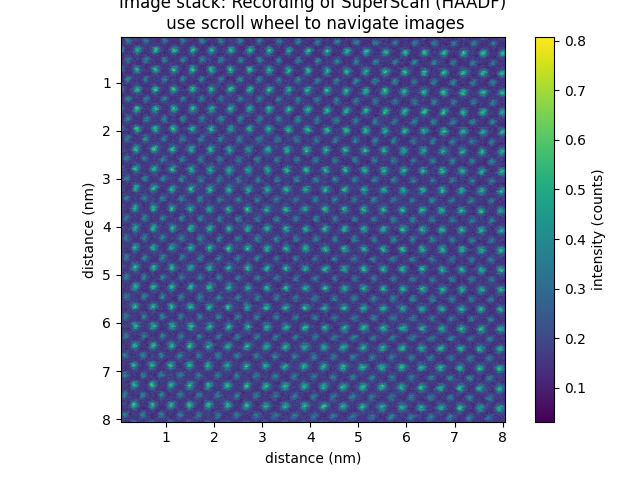

In [6]:
datasets = fileWidget.datasets

dataset = fileWidget.selected_dataset
if dataset.data_type.name != 'IMAGE_STACK':
    print('We really would need a stack of images here')
dataset.x.dimension_type  = 'spatial'    
dataset.y.dimension_type  = 'spatial'    
view = dataset.plot()

## First: Rigid Registration

If this is an image stack we need to register and add the images. 

Using sub-pixel accuracy registration determination method of:

Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup, “Efficient subpixel image registration algorithms,” Optics Letters 33, 156-158 (2008). [DOI:10.1364/OL.33.000156](https://www.doi.org/%2010.1364/OL.33.000156)

as implemented in ``phase_cross_correlation`` function by ``scikit-image`` in the [registration](https://scikit-image.org/docs/dev/api/skimage.registration.html) package. 

Stack contains  25  images, each with 512  pixels in x-direction and  512  pixels in y-direction


  0%|          | 0/25 [00:00<?, ?it/s]

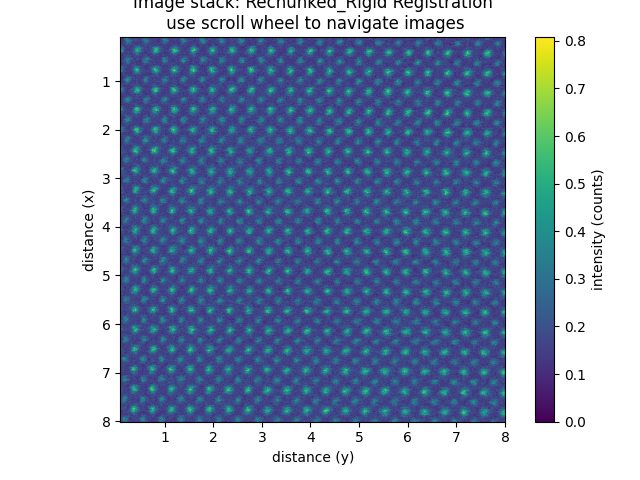

In [7]:
from pyTEMlib import image_tools
rigid_registered_dataset = image_tools.rigid_registration(dataset)
v = rigid_registered_dataset.plot()

### Determine Quality of Rigid Registration

First we fit a polynom of degree **polynom_degree** onto the drift of x and y separately.

The Nion STEMs are extremly stable and sub_pixel drift per image can be achieved.

A pixel of size 30pm distributed over 512 pixel (the size of many images) is obviously negletible.

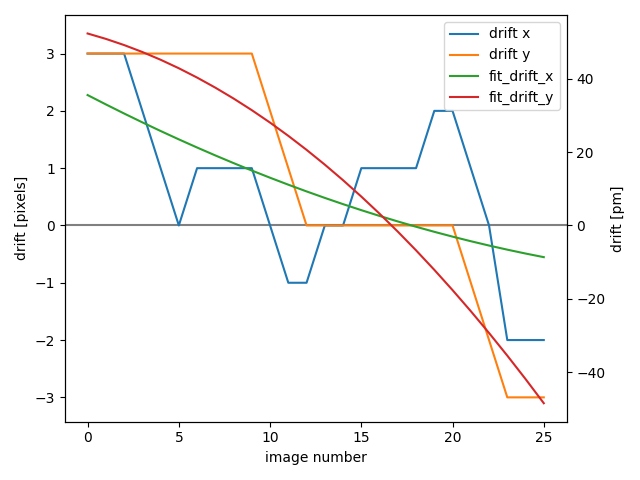

In [8]:
scale_x = file_tools.get_slope(rigid_registered_dataset.x.values)*1000.
drift = rigid_registered_dataset.metadata['drift']
x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...
line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)


plt.figure()
# plot drift and fit of drift
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')
plt.legend();

# set second axis in pico meter
ax_pixels = plt.gca()
ax_pixels.step(1, 1)
ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()
ax_pm.set_ylim(x_1*scale_x, x_2*scale_x)

# add labels
ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()

### Contrast
The image should have improved in contrast and signal noise ratio.

Contrast = 0.36


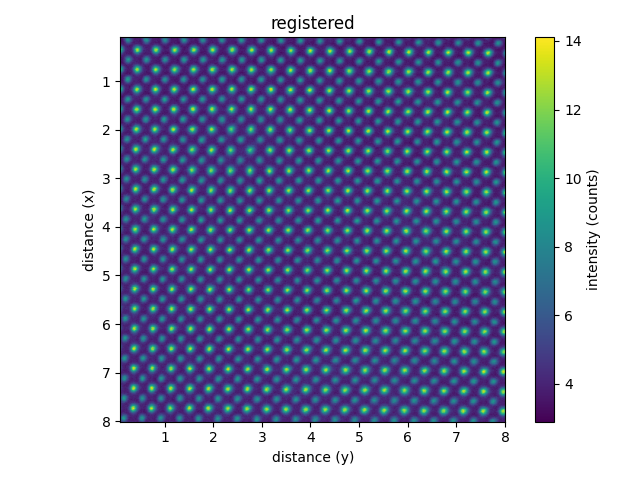

In [9]:
image = rigid_registered_dataset.sum(axis=0)
image.data_type = 'image'
image.title = 'registered'

image.set_dimension(0,rigid_registered_dataset.dim_1)
image.set_dimension(1,rigid_registered_dataset.dim_2)
print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view =image.plot()


In [14]:
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from scipy import ndimage
image = np.array(dataset[0])
offset_image = np.array(dataset[5])

# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image, super)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
shift_cc =np.array(ndimage.maximum_position(cc_image.real))-cc_image.shape[0]/2
print(shift)
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f'Detected pixel offset (y, x): {shift} by phase_cross_correlation')
print(f'Detected pixel offset (y, x): {shift_cc} by  normal cross_correlation')


# subpixel precision
shift, error, diffphase = phase_cross_correlation(image, offset_image,
                                                  upsample_factor=100)
print(shift)
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')
print(shift_cc)
# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift_cc*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

TypeError: phase_cross_correlation() takes 2 positional arguments but 3 were given

### Log Rigid Registration

We store the croped image-stack and drift-data here.

In [12]:
datasets['Log_000'] = image.copy()


## Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

  0%|          | 0/25 [00:00<?, ?it/s]

:-)
You have successfully completed Diffeomorphic Demons Registration


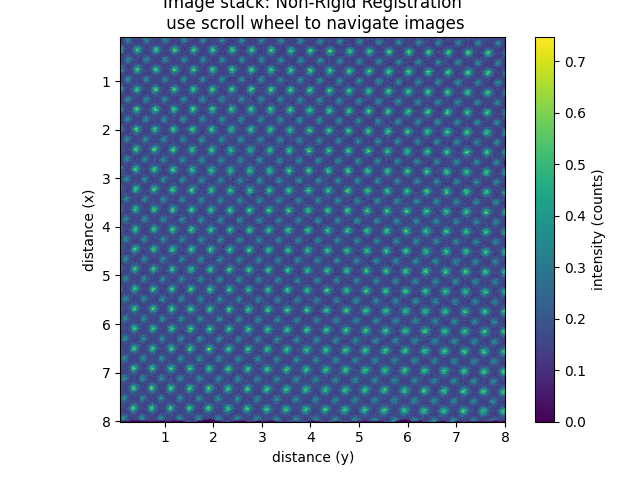

In [13]:
non_rigid_registered = image_tools.demon_registration(rigid_registered_dataset)

view = non_rigid_registered.plot()

### Contrast
The image should have improved in contrast and signal noise ratio.

Contrast = 0.38


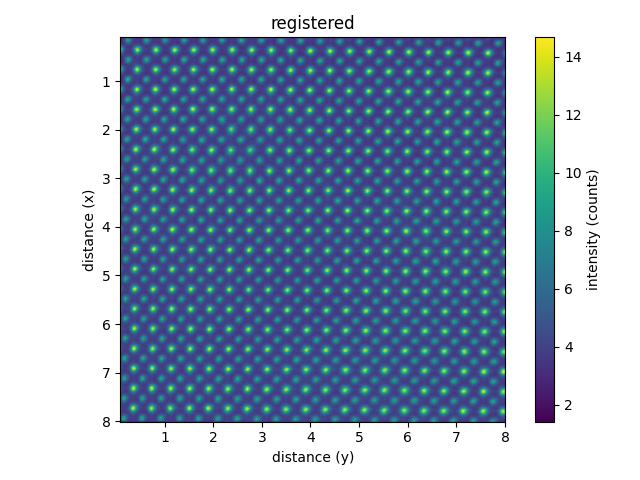

In [15]:
image = non_rigid_registered.sum(axis=0)
# image = image[:-4,:]
image.data_type = 'image'
image.title = 'registered'
# image.set_dimension(0,non_rigid_registered.dim_1)
# image.set_dimension(1,non_rigid_registered.dim_2)

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view = image.plot()

### Log Non-Rigid Registration

In [16]:
datasets['Log_001'] = non_rigid_registered

A tree-like plot of the file

## Comparison of Different Dataset

A convenient function to select a dataset (for further processing, visualization or whatever)

In [17]:
chooser = file_tools.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: Recording of SuperScan (HAADF)', 'Log_001: Non-…

The selected dataset can then easily be plotted

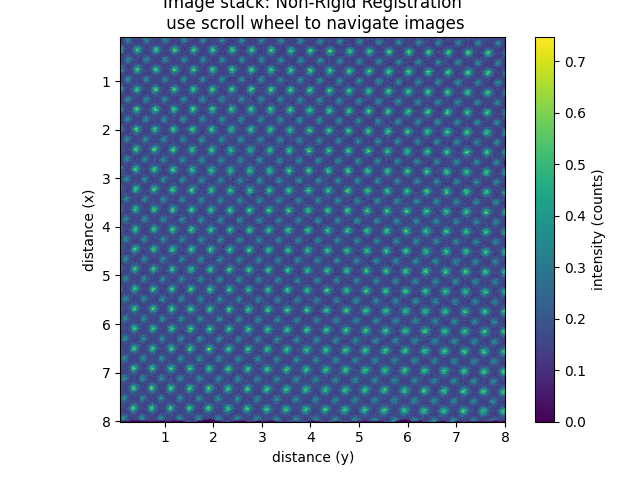

In [18]:
view = chooser.dataset.plot()

## Save File
let's save the datasets

In [19]:
h5_group = file_tools.save_dataset(datasets, filename=dataset.metadata['filename'])

could not save item  Log_000 of dataset dictionary


C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_io.py:111: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:Non-Rigid Registration to Non_Rigid Registration
  warn('main_data_name should not contain the "-" character. Reformatted'
C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


In [20]:
print('original file ', dataset.metadata['filename'])
print('was sved to: '+ h5_group.file.filename)

original file  C:\Users\gduscher\Documents\Github\ML-ElectronMicroscopy-2023\example_data\STO-stack.h5
was sved to: C:\Users\gduscher\Documents\Github\ML-ElectronMicroscopy-2023\example_data\STO-stack.hf5


Please note, that the file is still open, so we need to close it.

In [21]:
h5_group.file.close()

### Adaptive Fourier Filter 

In [22]:
chooser = ft.ChooseDataset(datasets)

NameError: name 'ft' is not defined

Contrast = 0.38


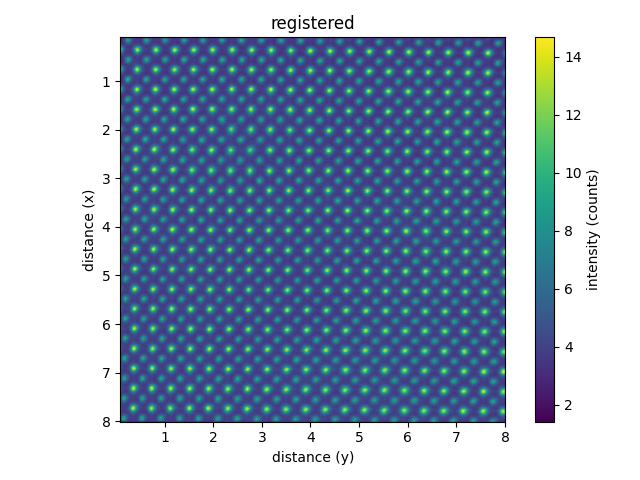

In [23]:
dataset = chooser.dataset
image = dataset.sum(axis=0)
image.data_type = 'image'
image.title = 'registered'

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view = image.plot()


fft :
	smoothing : 1
	minimum_intensity : 4.0496665893185035
	maximum_intensity : 11.399051967660967
source:  registered


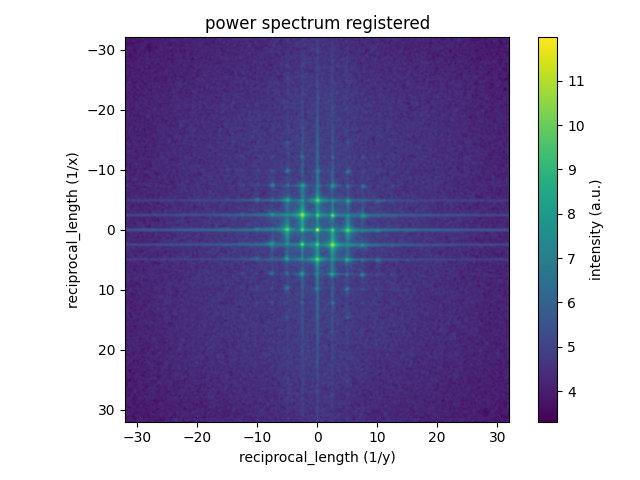

In [25]:
power_spectrum = image_tools.power_spectrum(image, smoothing=1)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = power_spectrum.plot()